<a href="https://colab.research.google.com/github/Nitzancohen1/HW3/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment3 <br>
### Names: Idan Bar Oz, Nitzan Cohen, Yanai Bardos

# Import libraries

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import re
from tqdm.notebook import tqdm
from keras_preprocessing import sequence
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from tensorflow.keras import layers
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding,LSTM
from keras_preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
from sklearn.metrics import accuracy_score
import nltk
from sklearn.model_selection import train_test_split


import plotly.express as px

from keras.utils import np_utils
from nltk.tokenize.toktok import ToktokTokenizer

# Loading the data

In [ ]:
train_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/train.csv?raw=true')
test_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/test.csv?raw=true')

# EDA

Let's look the data train

In [ ]:
train_df

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9


Representations of the shows in the data

In [ ]:
train_df['Show'].value_counts()

Friends     39092
Seinfeld    31313
Name: Show, dtype: int64

Let's plot it

In [ ]:
num_train_sample = len(train_df['Show'])
Friends_prob = sum(train_df['Show'][:] == 'Friends') / num_train_sample
Seinfeld_prob = sum(train_df['Show'][:] == 'Seinfeld') / num_train_sample
print('The percent of Friends in the train data: ',  Friends_prob)
print('The percent of Seinfeld in the train data: ', Seinfeld_prob)

class_names = ['Friends', 'Seinfeld']
n_images = [Friends_prob, Seinfeld_prob]
px.pie(names=class_names, values=n_images, width=400, height=400)

The percent of Friends in the train data:  0.5552446559193239
The percent of Seinfeld in the train data:  0.4447553440806761


We can see that there are more dialogues in Friends than in Seinfeld,
It's reasonable because Friends has more seasons than Seinfeld

Representations of the each shows's characters in the data

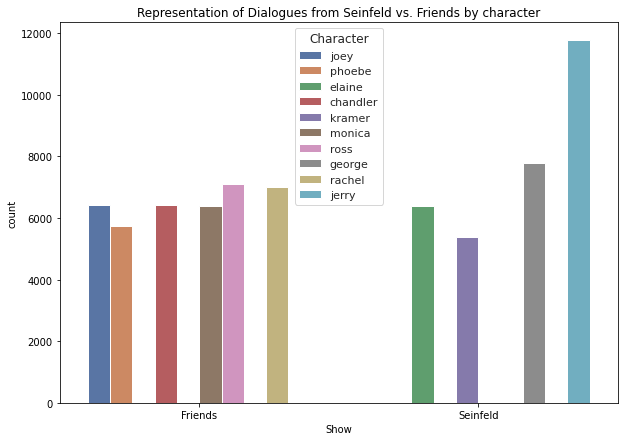

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Representation of Dialogues from Seinfeld vs. Friends by character')
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Show", data=train_df, hue='Character')
sns.move_legend(ax, "upper center")

We can see that in Friends the dialogues are divided equally, but in Seinfeld Jerry talks much than the others.

#Pre-processing

We use **only** dialogue and show columns for training

In [ ]:
X_train = train_df['Dialogue']
Y_train = train_df['Show']

In [ ]:
X_test = test_df['Dialogue']
Y_test = test_df['Show']

###Cleaning the data

In [ ]:
# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Define function for removing special characters
def remove_special_characters(text):
    pattern = r"[^A-Za-z0-9^,!.\/'+-=]>"
    text = re.sub(pattern,'',text)
    return text

# Removing the noisy text
def clean_text(text):
    text = remove_between_square_brackets(text)
    text=remove_special_characters(text)
    return text


# Apply function on data
X_train_clean = X_train.apply(clean_text)
X_test_clean=X_test.apply(clean_text)

Loading the stop words in English

In [ ]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Func for remove stop words
tqdm.pandas()
toktoktokenizer = ToktokTokenizer()
def remove_stopwords(text, is_lower_case=False):
    tokens = toktoktokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Apply function on data
X_train_clean = X_train_clean.progress_apply(remove_stopwords)
X_test_clean = X_test_clean.progress_apply(remove_stopwords)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

Word Normalization by Lemmatization



In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(lemmatized_text)
# Apply function on data
let_x_train_clean = X_train_clean.progress_apply(lemmatize)
let_x_test_clean = X_test_clean.progress_apply(lemmatize)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

We split the training data into training vs validation.
we use stratify to split the shows equally. 



In [ ]:
x_train, x_val, y_train, y_val = train_test_split(let_x_train_clean, Y_train, test_size=0.05, random_state=42, stratify = Y_train)

In [ ]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', let_x_test_clean.shape)
print('y_test shape:', Y_test.shape)

x_train shape: (66884,)
y_train shape: (66884,)
x_val shape: (3521,)
y_val shape: (3521,)
x_test shape: (4245,)
y_test shape: (4245,)


We need to convert the values of 'Friends' and 'Seinfeld' to ones and zeros:


In [ ]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(Y_test)
y_val = lb.transform(y_val)

Let's check it's work

In [ ]:
y_train[:10]

array([[0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0]])

## Deep learning

We will use Keras Tokenizer

In [ ]:
token = Tokenizer(lower=False)
token.fit_on_texts(x_train)

Converte Tokens to Sequences 

In [ ]:
x_train_dl = token.texts_to_sequences(x_train)
x_val_dl = token.texts_to_sequences(x_val)
x_test_dl = token.texts_to_sequences(X_test_clean)

We want to make sure that all sequences have the same length.<br>
We choose the len to be the max len of dialogue


In [ ]:
max_words = max(train_df['Dialogue_length'])
x_train_dl = sequence.pad_sequences(x_train_dl, maxlen=max_words)
x_val_dl = sequence.pad_sequences(x_val_dl, maxlen=max_words)
x_test_dl = sequence.pad_sequences(x_test_dl, maxlen=max_words)

Let's see a sample in the new train data

In [ ]:
x_train_dl[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

Let's check it's work

In [ ]:
x_train_dl.shape

(66884, 363)

In [ ]:
total_words = len(token.word_index) + 1 
total_words

22649

Let's build the model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=32, input_length=max_words))
model.add(Conv1D(8, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 363, 32)           724768    
                                                                 
 conv1d (Conv1D)             (None, 363, 8)            776       
                                                                 
 flatten (Flatten)           (None, 2904)              0         
                                                                 
 dense (Dense)               (None, 64)                185920    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 911,529
Trainable params: 911,529
Non-trai

Train the model

In [ ]:
modle_fitted = model.fit(x_train_dl, y_train, validation_data=(x_val_dl, y_val), epochs=5, batch_size=64)

Epoch 1/5
1046/1046 [==============================] - 42s 39ms/step - loss: 0.4845 - accuracy: 0.7286 - val_loss: 0.4182 - val_accuracy: 0.7688
Epoch 2/5
1046/1046 [==============================] - 48s 46ms/step - loss: 0.3724 - accuracy: 0.8101 - val_loss: 0.4160 - val_accuracy: 0.7827
Epoch 3/5
1046/1046 [==============================] - 48s 46ms/step - loss: 0.3165 - accuracy: 0.8398 - val_loss: 0.4438 - val_accuracy: 0.7742
Epoch 4/5
1046/1046 [==============================] - 43s 41ms/step - loss: 0.2747 - accuracy: 0.8611 - val_loss: 0.5028 - val_accuracy: 0.7762
Epoch 5/5
1046/1046 [==============================] - 50s 48ms/step - loss: 0.2435 - accuracy: 0.8768 - val_loss: 0.5612 - val_accuracy: 0.7717


Evaluate on the test data

In [ ]:
test_evaluate = model.evaluate(x_test_dl, y_test)

133/133 [==============================] - 1s 6ms/step - loss: 0.5407 - accuracy: 0.8591


Evaluate on the train data

In [ ]:
train_evaluate = model.evaluate(x_train_dl, y_train)

2091/2091 [==============================] - 12s 6ms/step - loss: 0.2074 - accuracy: 0.8969


Let's plot the result

In [ ]:
def summarize_diagnostics(fitted_model):
    plt.figure(figsize=(10, 10))
    # plot loss
    plt.subplot(211)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title('Cross Entropy Loss')
    plt.plot(fitted_model.history['loss'], color='blue', label='train')
    plt.plot(fitted_model.history['val_loss'], color='orange', label='valdation')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title('Classification Accuracy')
    plt.plot(fitted_model.history['accuracy'], color='blue', label='train')
    plt.plot(fitted_model.history['val_accuracy'], color='orange', label='valdation')
    plt.legend()


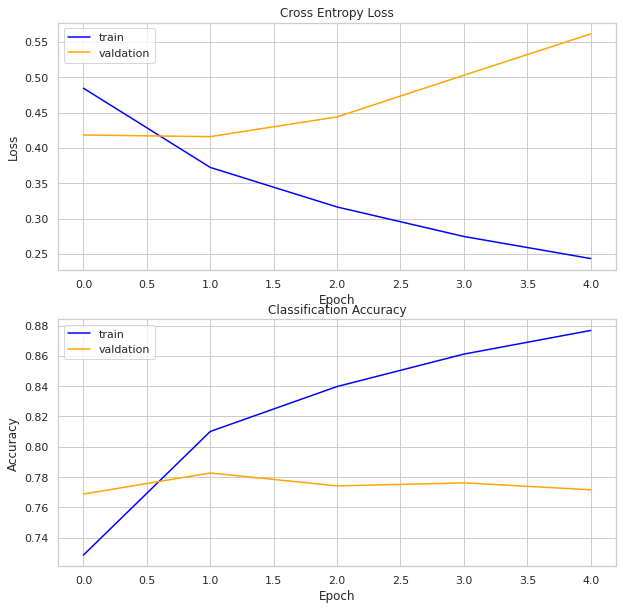

In [ ]:
summarize_diagnostics(modle_fitted)

Let's explore the result

We can visualize the embedding:

In [ ]:
token.word_index

{"'": 1,
 '’': 2,
 'know': 3,
 'Oh': 4,
 'Yeah': 5,
 'Well': 6,
 'like': 7,
 'Hey': 8,
 'get': 9,
 'right': 10,
 'go': 11,
 'think': 12,
 'gonna': 13,
 'Okay': 14,
 'got': 15,
 'guy': 16,
 'want': 17,
 'one': 18,
 'see': 19,
 'really': 20,
 'mean': 21,
 'look': 22,
 'uh': 23,
 'going': 24,
 'back': 25,
 'Ross': 26,
 'good': 27,
 'I': 28,
 'thing': 29,
 'Joey': 30,
 'Jerry': 31,
 'say': 32,
 'would': 33,
 '…': 34,
 'come': 35,
 'time': 36,
 'tell': 37,
 'little': 38,
 'Chandler': 39,
 'yeah': 40,
 'could': 41,
 'take': 42,
 'Monica': 43,
 'make': 44,
 'something': 45,
 'God': 46,
 'Rachel': 47,
 'okay': 48,
 'it': 49,
 'Yes': 50,
 'sorry': 51,
 'well': 52,
 'George': 53,
 'great': 54,
 'Hi': 55,
 'let': 56,
 'Phoebe': 57,
 'way': 58,
 'Uh': 59,
 'never': 60,
 'said': 61,
 'Look': 62,
 'love': 63,
 'you': 64,
 'need': 65,
 'Kramer': 66,
 'people': 67,
 'no': 68,
 'much': 69,
 'woman': 70,
 'big': 71,
 'u': 72,
 'Elaine': 73,
 'give': 74,
 'friend': 75,
 'two': 76,
 'man': 77,
 'gotta': 7

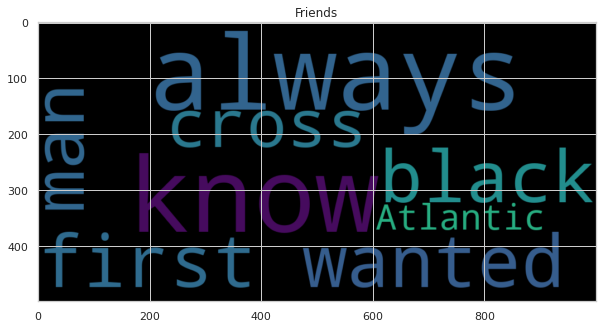

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize=(10, 10))
plt.title('Friends')
Friends_text = x_train[8]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
Friends_words = WC.generate(Friends_text)
plt.imshow(Friends_words, interpolation='bilinear')
plt.show()

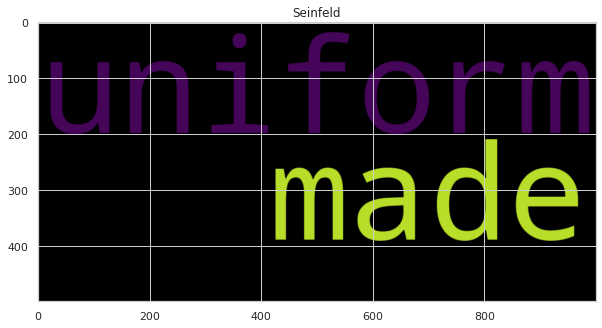

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Seinfeld')
Seinfeld_text = x_train[9]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
Seinfeld_words = WC.generate(Seinfeld_text)
plt.imshow(Seinfeld_words, interpolation='bilinear')
plt.show()

In [ ]:
character_acc_results_dict = {}
characters = set(test_df['Character'].values)

for character in characters:
  character_test_df = test_df.loc[test_df['Character'] == character]
  X_test = character_test_df['Dialogue']
  y_test = character_test_df['Show'].map({'Seinfeld': 1, 'Friends' : 0})
  character_test_df = X_test.apply(clean_text)
  character_test_df = X_test.progress_apply(remove_stopwords)
  character_test_df = X_test.progress_apply(lemmatize)
  X_test_sequences = token.texts_to_sequences(character_test_df)
  X_test_padded = sequence.pad_sequences(X_test_sequences, maxlen = max_words)

  _, acc = model.evaluate(X_test_padded, y_test, verbose=0)
  
  character_acc_results_dict[character] = acc

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/587 [00:00<?, ?it/s]

  0%|          | 0/587 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/382 [00:00<?, ?it/s]

  0%|          | 0/382 [00:00<?, ?it/s]

  0%|          | 0/474 [00:00<?, ?it/s]

  0%|          | 0/474 [00:00<?, ?it/s]

In [ ]:
character_acc_results_dict

{'phoebe': 0.9568527936935425,
 'ross': 0.9621052742004395,
 'chandler': 0.9318735003471375,
 'elaine': 0.42465752363204956,
 'jerry': 0.5400340557098389,
 'kramer': 0.5405405163764954,
 'rachel': 0.9458874464035034,
 'joey': 0.944915235042572,
 'monica': 0.945026159286499,
 'george': 0.4873417615890503}

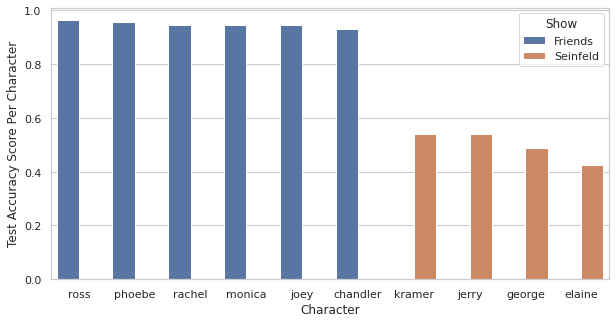

In [ ]:
character_acc_results_df =pd.DataFrame.from_dict(character_acc_results_dict, orient='index', columns=['Test Accuracy Score Per Character'])
character_acc_results_df = character_acc_results_df.sort_values(
    by='Test Accuracy Score Per Character', ascending=False)

character_acc_results_df = character_acc_results_df.merge(train_df[['Character', 'Show']], left_index=True, right_on='Character', how='left')
character_acc_results_df.drop_duplicates('Character').set_index('Character')

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=character_acc_results_df, x="Character", y="Test Accuracy Score Per Character", hue="Show")
plt.show()


We can see that the model did better on Friends characters than Seinfeld.


In [ ]:
results = {'model': ['NLP Model'],
              'Test score (Accuracy)': test_evaluate[1],
              'Train score (Accuracy)': train_evaluate[1],
              'Number of trainable parameters': 894729,
              'Number of layers': len(model.layers),
              'Regularization methods': 'Dropout',
              'Number of epochs': 5,
              'Loss function': 'binary_crossentropy',
              'Optimizer': 'Adam',
              'Embedding Dim': 32
              }

df = pd.DataFrame(results)
df

,model,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer,Embedding Dim
0,NLP Model,0.859128,0.896851,894729,6,Dropout,5,binary_crossentropy,Adam,32


In [ ]:
df.to_csv(os.path.join(os.getcwd(), 'exercise3.csv'))